<a href="https://colab.research.google.com/github/Raghoeveer/NeuralMachineTranslation_using_attention/blob/main/Neural_machine_translation_using_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext.datasets import IWSLT2017
import datasets
import numpy as np
import spacy
import random
from torch.utils.tensorboard import SummaryWriter
import torchtext
import matplotlib.pyplot as plt
import evaluate
%matplotlib inline
import tqdm


In [8]:
!python -m spacy download de_core_news_sm
!python -m spacy download en

2024-02-01 15:12:12.698295: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-01 15:12:12.698367: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-01 15:12:12.699533: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-01 15:12:13.763813: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 42.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')
2024-02-01 15:12:27.997922: E external/local_xla/xla/strea

In [9]:
# spacy_ger = spacy.load("de_core_news_sm")
# spacy_eng = spacy.load("en_core_web_sm")

# def tokenizer_ger(text):
#   return [tok.text for tok in spacy_ger.tokenizer(text)]

# def tokenizer_eng(text):
#   return [tok.text for tok in spacy_eng.tokenizer(text)]

# german = Field(tokenize = tokenizer_ger, lower = True, init_token = '<sos>', eos_token = '<eos>')
# english = Field(tokenize = tokenizer_eng, lower = True, init_token = '<sos>', eos_token = '<eos>')

# train_data, validation_data, test_data = Multi30k.splits(exts = (".de", ".en"), fields = (german, english))

In [10]:
dataset = datasets.load_dataset("bentrevett/multi30k")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [11]:
train_data, valid_data, test_data = (
    dataset["train"],
    dataset["validation"],
    dataset["test"],
)

In [12]:
en_nlp = spacy.load("en_core_web_sm")
de_nlp = spacy.load("de_core_news_sm")

In [13]:
def tokenize_example(example, en_nlp, de_nlp, max_length, sos_token, eos_token):
    en_tokens = [token.text for token in en_nlp.tokenizer(example["en"])][:max_length]
    de_tokens = [token.text for token in de_nlp.tokenizer(example["de"])][:max_length]
    en_tokens = [token.lower() for token in en_tokens]
    de_tokens = [token.lower() for token in de_tokens]
    en_tokens = [sos_token] + en_tokens + [eos_token]
    de_tokens = [sos_token] + de_tokens + [eos_token]
    return {"en_tokens": en_tokens, "de_tokens": de_tokens}

In [14]:
max_length = 1000
sos_token = "<sos>"
eos_token = "<eos>"

fn_kwargs = {
    "en_nlp": en_nlp,
    "de_nlp": de_nlp,
    "max_length": max_length,
    "sos_token": sos_token,
    "eos_token": eos_token,
}

train_data = train_data.map(tokenize_example, fn_kwargs=fn_kwargs)
valid_data = valid_data.map(tokenize_example, fn_kwargs=fn_kwargs)
test_data = test_data.map(tokenize_example, fn_kwargs=fn_kwargs)

Map:   0%|          | 0/29000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1014 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [15]:
min_freq = 2 #a word must atleast occur twice for it to be a part of the vocabulary
unk_token = "<unk>"
pad_token = "<pad>"

specials = [unk_token, pad_token, sos_token, eos_token]

eng_vocabulary = torchtext.vocab.build_vocab_from_iterator(train_data["en_tokens"], min_freq = min_freq, specials = specials,)
de_vocabulary = torchtext.vocab.build_vocab_from_iterator(train_data["de_tokens"], min_freq = min_freq, specials = specials,)



In [16]:
idx_unk = eng_vocabulary[unk_token]
idx_pad = eng_vocabulary[pad_token]

In [17]:
eng_vocabulary.set_default_index(idx_unk)
de_vocabulary.set_default_index(idx_unk)

In [18]:
def numericalize_example(example, en_vocab, de_vocab):
    en_ids = en_vocab.lookup_indices(example["en_tokens"])
    de_ids = de_vocab.lookup_indices(example["de_tokens"])
    return {"en_ids": en_ids, "de_ids": de_ids}

In [19]:
fn_kwargs = {"en_vocab": eng_vocabulary, "de_vocab": de_vocabulary}

train_data = train_data.map(numericalize_example, fn_kwargs=fn_kwargs)
valid_data = valid_data.map(numericalize_example, fn_kwargs=fn_kwargs)
test_data = test_data.map(numericalize_example, fn_kwargs=fn_kwargs)

Map:   0%|          | 0/29000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1014 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [20]:
data_type = "torch"
format_columns = ["en_ids", "de_ids"]

train_data = train_data.with_format(
    type=data_type, columns=format_columns, output_all_columns=True
)

valid_data = valid_data.with_format(
    type=data_type,
    columns=format_columns,
    output_all_columns=True,
)

test_data = test_data.with_format(
    type=data_type,
    columns=format_columns,
    output_all_columns=True,
)

In [21]:
def get_collate_fn(pad_index):
  def collate_fn(batch):
      batch_en_ids = [example["en_ids"] for example in batch]
      batch_de_ids = [example["de_ids"] for example in batch]
      batch_en_ids = nn.utils.rnn.pad_sequence(batch_en_ids, padding_value=pad_index)
      batch_de_ids = nn.utils.rnn.pad_sequence(batch_de_ids, padding_value=pad_index)
      batch = {
          "en_ids": batch_en_ids,
          "de_ids": batch_de_ids,
      }
      return batch

  return collate_fn

In [22]:
def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
  collate_fn = get_collate_fn(pad_index)
  data_loader = torch.utils.data.DataLoader(
      dataset=dataset,
      batch_size=batch_size,
      collate_fn=collate_fn,
      shuffle=shuffle,
  )
  return data_loader

In [23]:
batch_size = 64

train_data_loader = get_data_loader(train_data, batch_size, idx_pad, shuffle=True)
valid_data_loader = get_data_loader(valid_data, batch_size, idx_pad)
test_data_loader = get_data_loader(test_data, batch_size, idx_pad)

In [24]:
class Encoder(nn.Module):
  def __init__(self, input_size, embedding_size, hidden_size, num_layers, dropout):
    super(Encoder, self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.dropout = nn.Dropout(dropout)
    self.embedding = nn.Embedding(input_size, embedding_size)
    self.rnn = nn.LSTM(embedding_size, hidden_size, num_layers, bidirectional = True)

    self.fc_hidden = nn.Linear(hidden_size * 2, hidden_size) #2 hidden/cell states because bidirectional
    self.fc_cell = nn.Linear(hidden_size * 2, hidden_size)

  def forward(self, x):
    #x shape : (seq_length, N)

    embedding = self.dropout(self.embedding(x))
    # embedding shape : (sequence_length, N, embedding_size)

    encoder_states, (hidden, cell) = self.rnn(embedding)
    #outputs shape: (seq_length, N, hidden_size)

    #hidden shape: (2, N, hidden_size)
    hidden = self.fc_hidden(torch.cat((hidden[0:1], hidden[1:2]), dim = 2))
    cell = self.fc_cell(torch.cat((cell[0:1],  cell[1:2]), dim = 2))


    return encoder_states, hidden, cell

class Decoder(nn.Module):
  def __init__(self, input_size, embedding_size, hidden_size, output_size, num_layers, dropout):
    super(Decoder, self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.dropout = nn.Dropout(dropout)
    self.embedding = nn.Embedding(input_size, embedding_size)
    self.rnn = nn.LSTM(hidden_size * 2 + embedding_size, hidden_size, num_layers)
    self.energy = nn.Linear(hidden_size * 3, 1)  #Hidden state of encoder layer (2) + hidden state of previous decoder lstm unit (!)
    self.softmax = nn.Softmax(dim = 0)
    self.relu = nn.ReLU()
    self.fc = nn.Linear(hidden_size, output_size)


    self.fc = nn.Linear(hidden_size, output_size)

  def forward(self, x, encoder_states, hidden, cell):
    #shape of x (N) but we want (1, N)
    x = x.unsqueeze(0)

    embedding = self.dropout(self.embedding(x))
    #embedding shape = (1, N, embedding_size)

    sequence_length = encoder_states.shape[0]
    h_reshaped = hidden.repeat(sequence_length, 1, 1)

    energy = self.relu(self.energy(torch.cat((h_reshaped, encoder_states), dim = 2)))
    attention = self.softmax(energy)
    # (seq_length, N, 1)
    attention = attention.permute(1, 2, 0)
    # (n, 1, seq_length)
    encoder_states = encoder_states.permute(1, 0, 2)

    # (N, 1, hidden_size * 2) --> (1, N, hidden_size * 2)
    context_vector = torch.bmm(attention, encoder_states).permute(1, 0, 2)

    rnn_input = torch.cat((context_vector, embedding), dim = 2)

    outputs, (hidden, cell) = self.rnn(rnn_input, (hidden, cell))
    # shape of outputs : (1, N, hidden_size)

    predictions = self.fc(outputs)
    #shape of predictions: (1, N, vocab_len)

    predictions = predictions.squeeze(0)

    return predictions, hidden, cell


class Seq2Seq(nn.Module):
  def __init__(self, encoder, decoder):
    super(Seq2Seq, self).__init__()
    self.encoder = encoder
    self.decoder = decoder

  def forward(self, source, target, teacher_force_ratio = 0.5):
    batch_size = source.shape[1]
    target_len = target.shape[0]
    target_vocab_size = len(eng_vocabulary)

    outputs = torch.zeros(target_len, batch_size, target_vocab_size).to(device)

    encoder_states, hidden, cell = self.encoder(source)

    # grab the start token
    x = target[0]

    for t in range(1, target_len):
      output, hidden, cell = self.decoder(x, encoder_states, hidden, cell)

      outputs[t] = output
      #(N, eng_vocab_size)
      best_guess = output.argmax(1)
      x = target[t] if random.random() < teacher_force_ratio else best_guess

    return outputs


In [25]:
len(de_vocabulary)

7853

### Training loop

In [29]:
#Hyperparameters for training
num_epochs = 12
learning_rate = 0.001


#Hyper parameters for the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_size_encoder = len(de_vocabulary)
input_size_decoder = len(eng_vocabulary)
output_size = len(eng_vocabulary)
encoder_embedding_size = 300
decoder_embedding_size = 300
hidden_size = 1024
num_layers = 1
enc_dropout = 0.5
dec_dropout = 0.5

PATH = "model1.pt"

#Tensorboard
writer = SummaryWriter(f'run/loss_plot')
step = 0

encoder_net = Encoder(input_size_encoder, encoder_embedding_size, hidden_size, num_layers, enc_dropout).to(device)
decoder_net = Decoder(input_size_decoder, decoder_embedding_size, hidden_size, output_size, num_layers, dec_dropout).to(device)

model = Seq2Seq(encoder_net, decoder_net).to(device)

criterion = nn.CrossEntropyLoss(ignore_index = idx_pad)

optimizer = optim.Adam(model.parameters())

train_losses = []
val_losses = []

for epoch in range(num_epochs):
  epoch_loss = 0



  print(f'Epoch[{epoch} / {num_epochs}]')


  model.train()
  for batch_idx, batch in enumerate(train_data_loader):
    src = batch["de_ids"].to(device)
    trg = batch["en_ids"].to(device)

    output = model(src, trg)
    #output shape: (target_length, batch_size, output_dim)

    output = output[1:].reshape(-1, output.shape[2])
    trg = trg[1:].reshape(-1)

    optimizer.zero_grad()
    loss = criterion(output, trg)

    epoch_loss += loss.item()
    loss.backward()

    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm = 1)
    optimizer.step()



    writer.add_scalar('Training loss', loss, global_step = step)
    step += 1

  print(f"Training loss: {epoch_loss / len(train_data_loader)}")
  train_losses.append(epoch_loss / len(train_data_loader))
  epoch_loss = 0

  model.eval()
  with torch.no_grad():
    for batch_idx, batch in enumerate(valid_data_loader):
      src = batch["de_ids"].to(device)
      trg = batch["en_ids"].to(device)

      output = model(src, trg)
      #output shape: (target_length, batch_size, output_dim)

      output = output[1:].reshape(-1, output.shape[2])
      trg = trg[1:].reshape(-1)
      loss = criterion(output, trg)
      epoch_loss += loss.item()

    print(f"Validaition loss: {epoch_loss / len(valid_data_loader)}")
    val_losses.append(epoch_loss / len(valid_data_loader))

  torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, PATH)




Epoch[0 / 12]
Training loss: 4.4460675012697735
Validaition loss: 3.748520478606224
Epoch[1 / 12]
Training loss: 3.601987884433259
Validaition loss: 3.262908235192299
Epoch[2 / 12]
Training loss: 3.212889692856877
Validaition loss: 3.150416225194931
Epoch[3 / 12]
Training loss: 2.924886720821196
Validaition loss: 2.985358029603958
Epoch[4 / 12]
Training loss: 2.6821972315531997
Validaition loss: 2.895717069506645
Epoch[5 / 12]
Training loss: 2.4817377657092092
Validaition loss: 2.8795345723629
Epoch[6 / 12]
Training loss: 2.307573676634465
Validaition loss: 2.7648824751377106
Epoch[7 / 12]
Training loss: 2.1539595990979197
Validaition loss: 2.8275433033704758
Epoch[8 / 12]
Training loss: 2.014344757611531
Validaition loss: 2.8609733283519745
Epoch[9 / 12]
Training loss: 1.8954905654890422
Validaition loss: 2.8334539234638214
Epoch[10 / 12]
Training loss: 1.7805021397342766
Validaition loss: 2.8499915450811386
Epoch[11 / 12]
Training loss: 1.6908808203520753
Validaition loss: 2.88881886

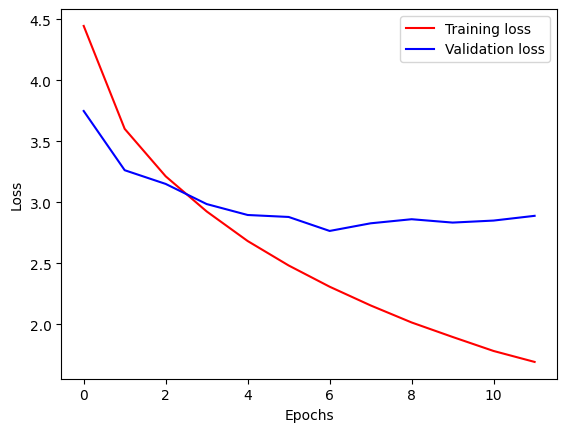

In [30]:
plt.plot(train_losses, label = 'Training loss', color = 'red')
plt.plot(val_losses, label = 'Validation loss', color = 'blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()